In [2]:
import sys
sys.path.append('..')

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

from config import supernodes_fpath, edges_lspace_fpath, edges_pspace_fpath, supernode_attributes_fpath, \
    edges_pspace_multi_fpath

from myutils.json import load_json, save_json

In [8]:
supernodes = pd.read_json(supernodes_fpath)

supernodes.head(2)

,id,stops,diameter,types,lat,lon
0,0,"[4609, 29290, 3082, 17005, 16142, 15984, 16466...",0.331043,"[bus, trolley, tram]",60.017943,30.367853
1,1,"[16964, 4677, 19280, 2545, 49, 26803, 26804, 1...",0.237753,"[bus, tram, trolley, subway]",59.990263,30.254647


___L-space___

In [6]:
weighted_edges = [tuple(item.values()) for item in load_json(edges_lspace_fpath)]

In [7]:
lspace = nx.Graph()
lspace.add_weighted_edges_from(weighted_edges)

len(lspace), len(lspace.edges)

(3226, 5352)

In [9]:
pos = dict(zip(supernodes['id'], supernodes[['lon', 'lat']].values))

In [10]:
components = list(nx.connected_components(lspace))
color = {node: f'C{i}' for i, comp in enumerate(components) for node in comp}
color = [color[node] for node in lspace]

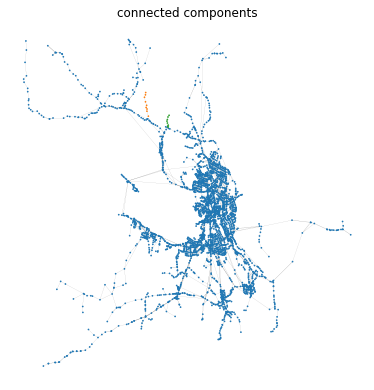

In [11]:
plt.figure(figsize=(5, 5))
nx.draw(lspace, pos, node_size=0.5, width=0.05, node_color=color)
plt.title('connected components');

___P-space___

In [12]:
weighted_edges = [tuple(item.values()) for item in load_json(edges_pspace_fpath)]

In [13]:
pspace = nx.Graph()
pspace.add_weighted_edges_from(weighted_edges)

len(pspace), len(pspace.edges)

(3226, 120039)

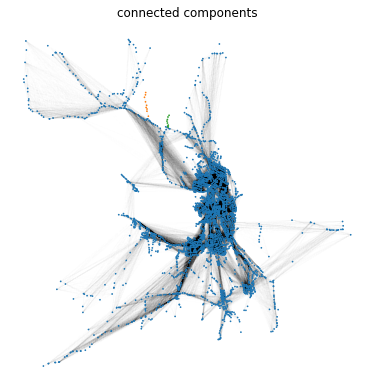

In [14]:
plt.figure(figsize=(5, 5))
nx.draw(pspace, pos, node_size=0.5, width=0.002, node_color=color)
plt.title('connected components');

## Synthetic trajectories from hotels to sightseeing places 

In [15]:
# converts shortest path in p-space into shortest path in l-space
def convert_pspace_path(p_path):
    l_path = [p_path[0]]
    for i in range(len(p_path) - 1):
        l_path += nx.shortest_path(lspace, p_path[i], p_path[i+1])[1:]
    return l_path

In [16]:
supernode_attributes_json = pd.read_json(supernode_attributes_fpath)

In [17]:
supernode_attributes_json.columns

Index(['id', 'residential_building', 'shop', 'catering_place', 'service',
       'medicine', 'sight_place_tourism', 'education', 'sport', 'car_supply',
       'company', 'organisation', 'supermarket', 'hotel_business',
       'electronics_and_telecommunication', 'industrial', 'bank_and_money',
       'printing_and_books', 'religion', 'post_office',
       'business_center_or_mall_or_marketplace'],
      dtype='object')

In [18]:
tourism_ids = supernode_attributes_json[supernode_attributes_json.sight_place_tourism > 0].id.tolist()

In [19]:
hotel_ids = supernode_attributes_json[supernode_attributes_json.hotel_business > 0].id.tolist()

In [20]:
# takes about 10 min to execute
gaps = {}
for i in hotel_ids:
    for j in tourism_ids:      
        if i != j:
            try:
                p_space_path = nx.shortest_path(pspace, i, j)
            except:
                pass
            l_space_path = convert_pspace_path(p_space_path)
            len_l = len(l_space_path)
            for n in range(len_l - 1):
                key = set([l_space_path[n], l_space_path[n-len_l+1]])
                key = tuple(key)
                gaps[key] = gaps.get(key, 0) + 1

In [21]:
list_of_gaps = list(gaps.items())

In [22]:
for i in range(len(list_of_gaps)):
    list_of_gaps[i] = list_of_gaps[i][0] + tuple([list_of_gaps[i][1]])

In [23]:
# edges and weights
list_of_gaps[:10]

[(120, 3, 25865),
 (120, 51, 6232),
 (0, 51, 14258),
 (33, 3, 49439),
 (33, 1, 21836),
 (3, 118, 17689),
 (116, 118, 20368),
 (322, 116, 46805),
 (322, 204, 64598),
 (204, 4, 37796)]

In [24]:
# graph
G_hot_tour = nx.Graph()
G_hot_tour.add_weighted_edges_from(list_of_gaps)

len(G_hot_tour), len(G_hot_tour.edges)

(2644, 4442)

In [25]:
components = list(nx.connected_components(G_hot_tour))
color = {node: f'C{i}' for i, comp in enumerate(components) for node in comp}
color = [color[node] for node in G_hot_tour]

In [26]:
edges, weights = zip(*nx.get_edge_attributes(G_hot_tour,'weight').items())

Text(0.5, 1.0, 'Trajectories "hotels <--> tourism places"')

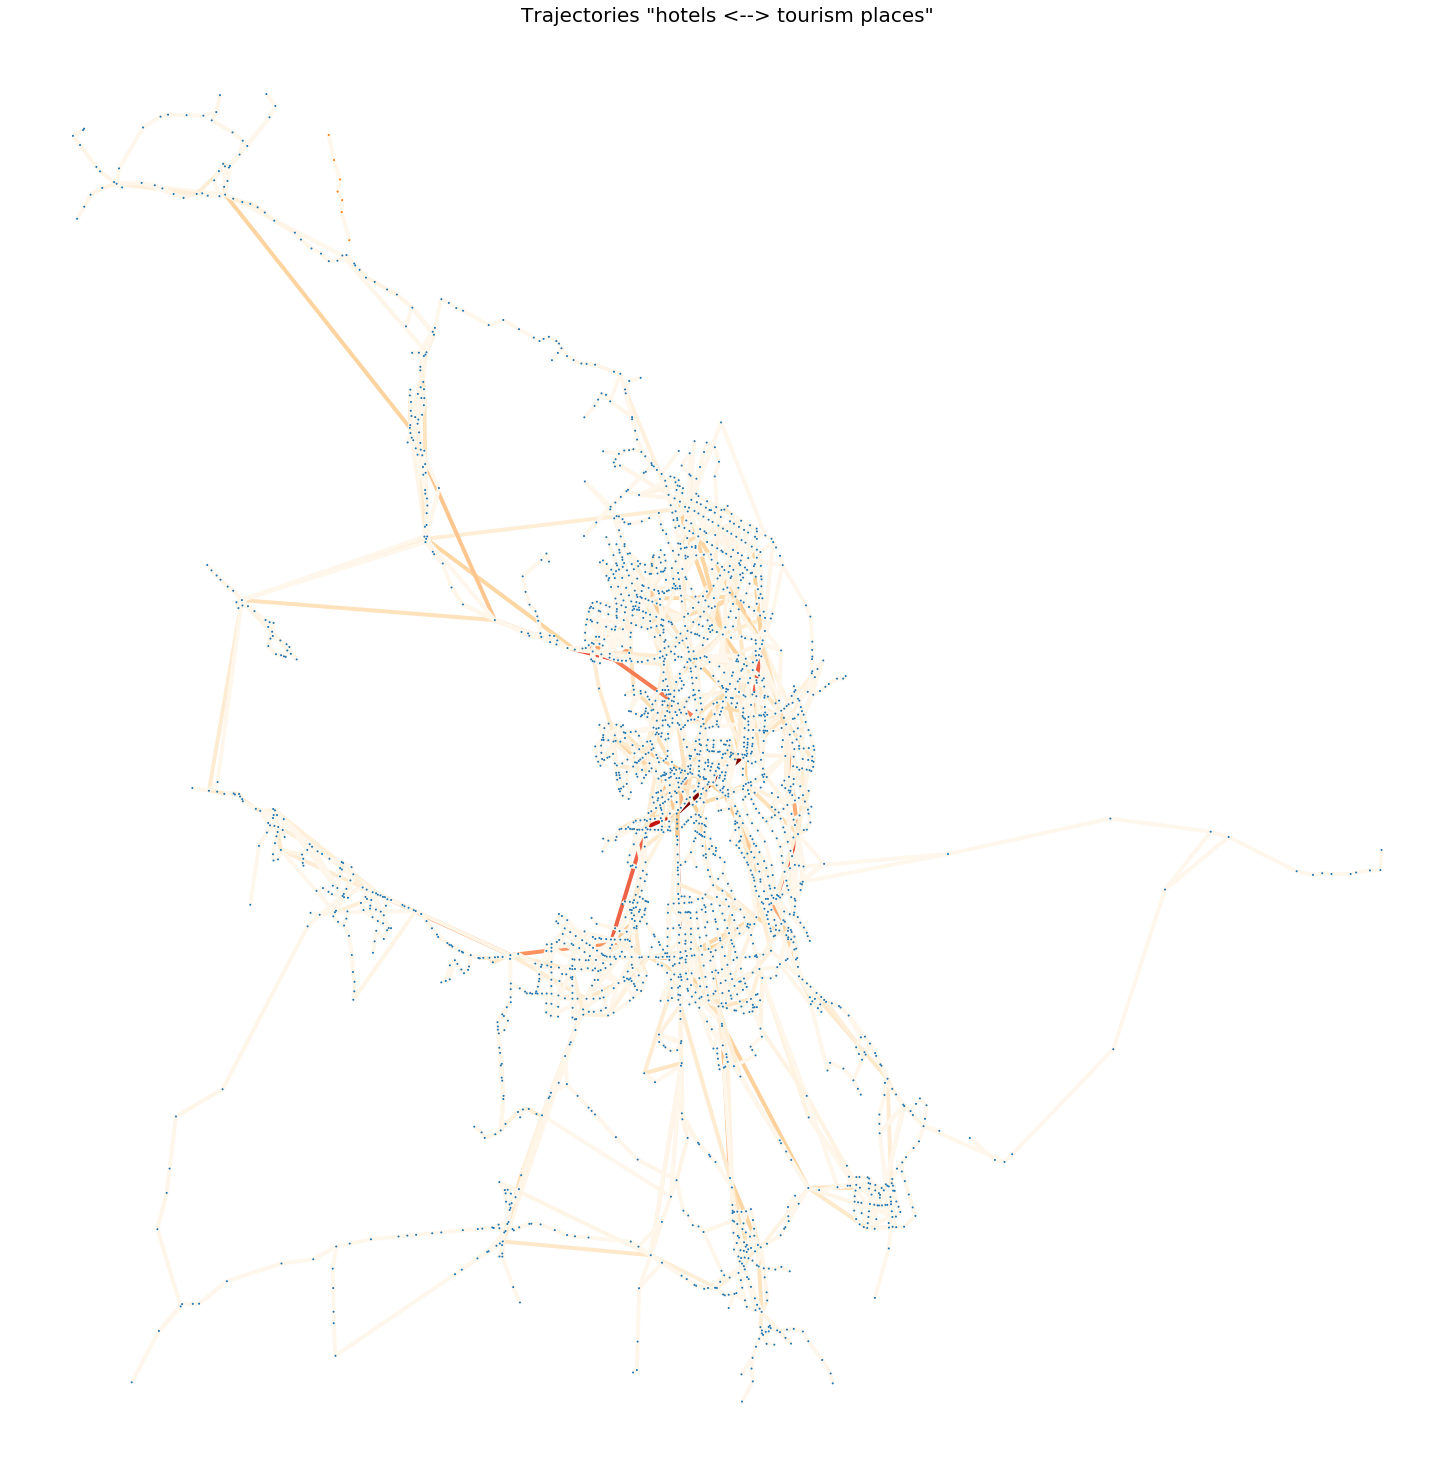

In [31]:
plt.figure(figsize=(20, 20))
nx.draw(G_hot_tour, pos, node_size=1, edge_color=weights, width=4, node_color=color, edge_cmap=plt.cm.OrRd)

# nx.draw(G_hot_tour, pos, node_size=1, edge_color=weights, width=4, node_color=color, edge_cmap=plt.cm.Reds)
plt.title('Trajectories "hotels <--> tourism places"', fontsize=20)

In [32]:
# save_json(list_of_gaps, 'trajectories_graph.json')